In [1]:
%%bash
nrnivmodl

/usr/bin/xcrun
/Users/anatolii-sorokin/Documents/Projects/neuro-trafic
Mod files: "./h.mod" "./kadist.mod" "./kaprox.mod" "./kdrca1.mod" "./km.mod" "./na3n.mod" "./naxn.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import math
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm
%matplotlib inline
np.random.seed(123456789)

DC = 10 # diffusion coeff [microns^2 s^-1]

# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')
h.tstop = 700.0

	0 
total # of segments (50Hz): 742   max path distance: 853.32493 
apical 0  dend_5[0]
apical 1  dend_5[15]
apical 2  dend_5[14]
apical 3  dend_5[13]
apical 4  dend_5[12]
apical 5  dend_5[12]
apical 6  dend_5[12]
apical 7  dend_5[12]
apical 8  dend_5[12]
apical 9  dend_5[12]
apical 10  dend_5[12]
apical 11  dend_5[11]
apical 12  dend_5[11]
apical 13  dend_5[11]
apical 14  dend_5[10]
apical 15  dend_5[9]
apical 16  dend_5[8]
apical 17  dend_5[8]
apical 18  dend_5[8]
apical 19  dend_5[7]
apical 20  dend_5[6]
apical 21  dend_5[5]
apical 22  dend_5[5]
apical 23  dend_5[5]
apical 24  dend_5[5]
apical 25  dend_5[5]
apical 26  dend_5[5]
apical 27  dend_5[5]
apical 28  dend_5[4]
apical 29  dend_5[4]
apical 30  dend_5[4]
apical 31  dend_5[3]
apical 32  dend_5[2]
apical 33  dend_5[2]
apical 34  dend_5[2]
apical 35  dend_5[2]
apical 36  dend_5[2]
apical 37  dend_5[2]
apical 38  dend_5[2]
apical 39  dend_5[1]
apical 40  dend_5[1]
apical 41  dend_5[1]
#1


In [3]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
N = len(seg_list)
n = N

In [4]:
import re
import pandas as pd
p = re.compile("^([^\\[]+)\\[.+")
tps = [p.sub("\\1",seg.sec.name()) for seg in seg_list]
pd.Series(tps).drop_duplicates().tolist()

['soma', 'dend_5', 'apic', 'dend', 'axon']

Read Experimental Data
----

In [5]:
tdf=pd.read_csv('data/seg_mapping.csv')
abbCA1=tdf['abb']
abbT={}
segIdx={}
for i in range(N):
    abbT[abbCA1[i]] = 1+ abbT.get(abbCA1[i],0)
    ll=segIdx.get(abbCA1[i],[])
    ll.append(i)
    segIdx[abbCA1[i]] = ll

(abbCA1,abbT,segIdx.keys(),{k:len(segIdx.get(k)) for k in segIdx.keys()})

(0       Soma_0
 1       Soma_0
 2      CA1sr_1
 3      CA1sr_1
 4      CA1sr_2
         ...   
 737        NaN
 738        NaN
 739        NaN
 740        NaN
 741        NaN
 Name: abb, Length: 742, dtype: object,
 {'Soma_0': 2,
  'CA1sr_1': 3,
  'CA1sr_2': 6,
  'CA1sr_3': 29,
  'CA1sr_4': 37,
  'CA1sr_5': 48,
  'CA1sr_6': 44,
  'CA1sr_7': 46,
  'CA1sr_8': 38,
  'CA1sr_9': 21,
  'CA1sr_10': 9,
  'CA1slm_1': 13,
  'CA1slm_2': 24,
  'CA1slm_3': 35,
  'CA1slm_4': 29,
  'CA1slm_5': 9,
  'CA1so_5': 16,
  'CA1so_4': 100,
  'CA1so_3': 134,
  'CA1so_2': 85,
  'CA1so_1': 9,
  nan: 5},
 dict_keys(['Soma_0', 'CA1sr_1', 'CA1sr_2', 'CA1sr_3', 'CA1sr_4', 'CA1sr_5', 'CA1sr_6', 'CA1sr_7', 'CA1sr_8', 'CA1sr_9', 'CA1sr_10', 'CA1slm_1', 'CA1slm_2', 'CA1slm_3', 'CA1slm_4', 'CA1slm_5', 'CA1so_5', 'CA1so_4', 'CA1so_3', 'CA1so_2', 'CA1so_1', nan]),
 {'Soma_0': 2,
  'CA1sr_1': 3,
  'CA1sr_2': 6,
  'CA1sr_3': 29,
  'CA1sr_4': 37,
  'CA1sr_5': 48,
  'CA1sr_6': 44,
  'CA1sr_7': 46,
  'CA1sr_8': 38,
  'CA1sr_9'

In [6]:
sname=[]
hname=[]
for i in range(len(seg_list)):
    sec = seg_list[i].sec
    sname.append(sec.name())
    hname.append(sec.hname())
#(sname,hname)

In [7]:
ks=[i for i in segIdx.keys()]
(ks[0],segIdx[ks[0]])

('Soma_0', [0, 1])

In [8]:
for i in segIdx[ks[0]]:
    sec = seg_list[i].sec
    print(f"{i}: {sec.name()}, nseg={sec.nseg}, L={sec.L}, or={sec.orientation()}, hname={sec.hname()}")

0: soma[0], nseg=1, L=15.166100084781647, or=0.0, hname=soma[0]
1: soma[1], nseg=1, L=10.883900105953217, or=0.0, hname=soma[1]


In [9]:
expD=pd.read_csv('data/CA1_gradient.csv')
subreg = ['CA1so', 'CA1sr', 'CA1slm']
expD

,Abbreviation,Subregion,D0W3_MEAN,D0W3_SD,D7W3_MEAN,D7W3_SD,D0M3_MEAN,D0M3_SD,D7M3_MEAN,D7M3_SD,D0M318_MEAN,D0M318_SD,D7M318_MEAN,D7M318_SD
0,CA1so_1,CA1so,57.666667,14.497175,2.306667,3.262119,58.820000,7.474454,25.373333,4.315378,68.046667,6.524239,29.986667,1.631060
1,CA1so_2,CA1so,89.960000,12.946135,5.766667,8.155298,87.653333,8.155298,44.980000,2.825078,94.573333,1.631060,51.900000,5.650156
2,CA1so_3,CA1so,100.340000,14.948909,6.920000,9.786358,96.880000,9.786358,51.900000,4.893179,101.493333,3.262119,57.666667,7.109624
3,CA1so_4,CA1so,99.186667,14.497175,5.766667,8.155298,96.880000,9.786358,46.133333,7.109624,103.800000,2.825078,53.053333,8.630756
4,CA1so_5,CA1so,83.040000,17.642608,2.306667,3.262119,87.653333,10.695573,28.833333,7.109624,98.033333,3.262119,32.293333,9.921348
5,CA1sr_1,CA1sr,70.353333,10.695573,3.460000,4.893179,69.200000,7.474454,29.986667,3.262119,74.966667,3.262119,36.906667,4.315378
6,CA1sr_2,CA1sr,89.383333,12.341206,5.766667,8.155298,80.733333,8.155298,36.906667,5.880869,85.346667,1.631060,42.673333,5.880869
7,CA1sr_3,CA1sr,94.573333,13.350799,6.920000,9.786358,84.193333,10.695573,40.943333,5.708709,88.806667,1.631060,48.440000,4.893179
8,CA1sr_4,CA1sr,95.726667,11.761738,8.073333,11.417417,85.346667,9.081356,44.980000,4.893179,88.806667,4.315378,53.053333,5.880869
9,CA1sr_5,CA1sr,94.573333,10.695573,9.226667,13.048477,84.193333,8.155298,47.286667,5.880869,87.653333,4.315378,55.360000,5.650156


In [10]:
import sushibelt
import Edita_20reg_1dv_dual_model_soma as model
import time

	0 
total # of segments (50Hz): 742   max path distance: 853.32493 
apical 0  dend_5[0]
apical 1  dend_5[15]
apical 2  dend_5[14]
apical 3  dend_5[13]
apical 4  dend_5[12]
apical 5  dend_5[12]
apical 6  dend_5[12]
apical 7  dend_5[12]
apical 8  dend_5[12]
apical 9  dend_5[12]
apical 10  dend_5[12]
apical 11  dend_5[11]
apical 12  dend_5[11]
apical 13  dend_5[11]
apical 14  dend_5[10]
apical 15  dend_5[9]
apical 16  dend_5[8]
apical 17  dend_5[8]
apical 18  dend_5[8]
apical 19  dend_5[7]
apical 20  dend_5[6]
apical 21  dend_5[5]
apical 22  dend_5[5]
apical 23  dend_5[5]
apical 24  dend_5[5]
apical 25  dend_5[5]
apical 26  dend_5[5]
apical 27  dend_5[5]
apical 28  dend_5[4]
apical 29  dend_5[4]
apical 30  dend_5[4]
apical 31  dend_5[3]
apical 32  dend_5[2]
apical 33  dend_5[2]
apical 34  dend_5[2]
apical 35  dend_5[2]
apical 36  dend_5[2]
apical 37  dend_5[2]
apical 38  dend_5[2]
apical 39  dend_5[1]
apical 40  dend_5[1]
apical 41  dend_5[1]
#1


2024-08-26 15:14:45,361 :: INFO :: data read
2024-08-26 15:14:45,362 :: INFO :: calcUtrace function defined


In [21]:
bgSignal = 1e-5
cname0='D0M3'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

#cname='D7W3'
cname7='D7M3'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
day7 = 7 * 24 * 3600 # final time point

itarg = np.ones(N, dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= (i+5)

#par = [0.0037409943078160948,-8.977435487076244,0.10296875669107215,-5.985592752226426,-17.998608618492327,2.0917391382090793,0.781047528597352,0.12849634147422345,0.08946763398622723,0.11749157263698012,0.66685768626628,1.0,1.0,0.36249051456945974,0.2847875213769458,0.21824108940755482,0.23294443337178591,0.22369665977811437,0.2667571575893474,0.4759416999809596,1.0,0.47506558432641843,0.3360528182657583,0.26507210047494595,0.3406854559448753,0.9999999990293594]
#cost = 0.0015914289930259863
#chi2_0 = 44.18288323756103
#chi2_1 = 55.66662416514183
#par = [1.0,-17.89748812285155,0.01,-18.0,-17.096587064118197,2.9999999999999982,0.7964990853712798,0.6453665545131553,0.5322399222172057,0.9999999999999988,0.9994832427116185,0.9999999999999996,0.09327896279252773,0.006286509485374208,0.27789238799503596,0.9855147041812389,0.025787964050873795,0.5543477746161413,0.9999999999999993,0.0506594814856503,0.23959071461095194,0.29483399803931015,0.27516951463552686,0.7211894889937414,0.8487495669306371,0.7094155816334369]
#cost = 0.011482838552877659
#chi2_0 = 1393.6136549066032
#chi2_1 = 1.2842080963433098e-11
#par = [0.8671703901171199,-14.749414044710475,0.37966800379594495,-14.074980333325268,-4.683303251102071,-2.319987222651057,1.0253620793240793e-07,0.9999999999999984,0.9994278813059569,0.1612468915466767,0.2986909173263714,0.2179778652958878,0.7567532755242995,6.375326285675256e-05,0.7008110062934803,0.9999483957415454,0.7435774369984808,0.42143055354321646,0.9610078251459555,0.6193683561120303,0.6858354447405187,0.9782845518342739,0.0015070142407858358,0.6925193322818234,1.000006198574278e-07,1.0250121942762678e-07]
#cost = 0.05273517470148647
#chi2_0 = 1663.0775177278522
#chi2_1 = 3399.7164725838184
#par = [0.8000000007030141,-18.0,0.9899999999999998,-18.0,-12.375541207829448,2.999999999954805,0.9997266427888488,0.9633996712737807,0.6631438899322658,1.0250913638541285e-07,1.0,0.4902084977343629,0.3447550946835215,0.48884878990159575,1.004562495887449e-07,0.6219426415989302,0.46209827367575634,0.9999506308840785,0.7277884036270305,1.0,0.23229067102200748,0.968955802094482,0.5055122627972007,0.48338584032658083,0.5087082480560876,0.804965800600292]
#cost = 0.058134643384845835
#chi2_0 = 1393.612685478813
#chi2_1 = 3.2598451288738365e-08
#par = [0.681542340324794,-13.599896889285919,0.5332153812984872,-4.214726857689942,-12.361268660112586,-3.0,0.5743852670422149,0.9985194360270204,0.2883264707970568,0.5606673016003165,0.9882603779927778,0.9990702357057785,0.9846730736831185,0.995113013722513,0.9238101524706092,0.9121343841397045,0.679483273773553,0.3451340402640768,0.8275455216794205,0.9351915153870317,0.05822655460365266,0.9994442512912389,0.32332927828802455,0.5237870302983164,0.5569379390004419,0.9058077208225012]
#cost = 0.06584970433204818
#chi2_0 = 1953.6241392104141
#chi2_1 = 6589.114696633933
par = [1.5950338606692782e-05,-8.006923947781186,0.8999999999999879,-7.0,-17.99984016564933,-0.9630324046065661,0.5676742862480186,0.08926340006875749,0.06276603945764056,0.08331276204946536,0.4591075531247846,1.0,1.0,0.254594502390868,0.20243453195143307,0.1523824962403711,0.16538109174916044,0.16083159434580513,0.19266333413847858,0.3403997783360564,0.696428215374356,0.3369989463380175,0.24813209135501102,0.19418071554160143,0.24628798145217556,0.8016536371787428]
cost = 0.03413428717503831
chi2_0 = 1347.734730988346
chi2_1 = 19.447812425587685
mProp = par[2]
costWeight=[1,1,.05,.01]
utrace = model.calcUtrace(par)
resM0, resF0 = sushibelt.aggregate_segments(utrace[:2*N, -1], segIdx, expD['Abbreviation'], fun=np.sum)
resM1, resF1 = sushibelt.aggregate_segments(utrace[2 * N:, -1], segIdx, expD['Abbreviation'], fun=np.sum)


In [22]:
{'F' : par[0],
'Ctau' : 10 ** par[1],
'mProp' : par[2],
'dvA' : par[3],
'dvB' : par[4],
'tr' : 10 ** par[5],
'demand_CA1so_1' : par[6],
'demand_CA1so_2' : par[7],
'demand_CA1so_3' : par[8],
'demand_CA1so_4' : par[9],
'demand_CA1so_5' : par[10],
'demand_CA1sr_1' : par[11],
'demand_CA1sr_2' : par[12],
'demand_CA1sr_3' : par[13],
'demand_CA1sr_4' : par[14],
'demand_CA1sr_5' : par[15],
'demand_CA1sr_6' : par[16],
'demand_CA1sr_7' : par[17],
'demand_CA1sr_8' : par[18],
'demand_CA1sr_9' : par[19],
'demand_CA1sr_10' : par[20],
'demand_CA1slm_1' : par[21],
'demand_CA1slm_2' : par[22],
'demand_CA1slm_3' : par[23],
'demand_CA1slm_4' : par[24],
'demand_CA1slm_5' : par[25],
'sum_resM0' : np.sum(resM0),
'sum_resF0' : np.sum(resF0),
'sum_resM1' : np.sum(resM1),
'sum_resF1' : np.sum(resF1),
'sum_tot_0' : np.sum(resF0)+np.sum(resM0),
'sum_tot_1' : np.sum(resF1)+np.sum(resM1),
'sum_target0' : np.sum(model.target0),
'sum_target7' : np.sum(model.target7),
'cost0 ' :  np.sum((resF0 / (1 - mProp) - model.target7) ** 2),
'cost1 ' :  np.sum((resF1 / (1 - mProp) - model.target0) ** 2),
'cost2' : np.abs(np.sum(resF0) + np.sum(resM0) - model.tnorm7),
'cost3' : np.abs(np.sum(resF1) + np.sum(resM1) - model.tnorm0),
'costT ' : np.sum((resF0 / (1 - mProp) - model.target7) ** 2)+ np.sum((resF1 / (1 - mProp) - model.target0) ** 2),
'chi2_0 ' :  np.sum(((resF0 / (1 - mProp) - model.target7) / model.targ7SD) ** 2),
'chi2_1 ' :  np.sum(((resF1 / (1 - mProp) - model.target0) / model.targ0SD) ** 2),
'cost' : cost,
'Chi2_0' : chi2_0,
'Chi2_1' : chi2_1
}

{'F': 1.5950338606692782e-05,
 'Ctau': 9.841834376326384e-09,
 'mProp': 0.8999999999999879,
 'dvA': -7.0,
 'dvB': -17.99984016564933,
 'tr': 0.108884884653818,
 'demand_CA1so_1': 0.5676742862480186,
 'demand_CA1so_2': 0.08926340006875749,
 'demand_CA1so_3': 0.06276603945764056,
 'demand_CA1so_4': 0.08331276204946536,
 'demand_CA1so_5': 0.4591075531247846,
 'demand_CA1sr_1': 1.0,
 'demand_CA1sr_2': 1.0,
 'demand_CA1sr_3': 0.254594502390868,
 'demand_CA1sr_4': 0.20243453195143307,
 'demand_CA1sr_5': 0.1523824962403711,
 'demand_CA1sr_6': 0.16538109174916044,
 'demand_CA1sr_7': 0.16083159434580513,
 'demand_CA1sr_8': 0.19266333413847858,
 'demand_CA1sr_9': 0.3403997783360564,
 'demand_CA1sr_10': 0.696428215374356,
 'demand_CA1slm_1': 0.3369989463380175,
 'demand_CA1slm_2': 0.24813209135501102,
 'demand_CA1slm_3': 0.19418071554160143,
 'demand_CA1slm_4': 0.24628798145217556,
 'demand_CA1slm_5': 0.8016536371787428,
 'sum_resM0': 0.8862120209101167,
 'sum_resF0': 0.09932026042309469,
 'sum_r

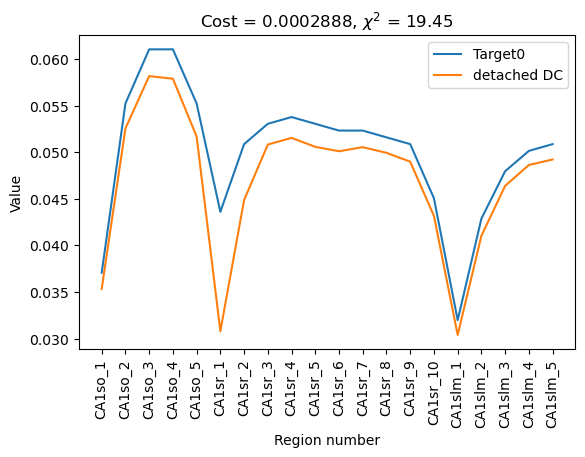

In [23]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.plot(x,model.target0,label='Target0')
#ax.plot(x,resM1,label='mobile DC')
ax.plot(x,resF1 / (1 - mProp),label='detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF1 / (1 - mProp) - model.target0) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF1 / (1 - mProp) - model.target0) / model.targ0SD) ** 2),'.4g')}") 
# function to show the plot
plt.show()
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.png')
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.pdf')
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.svg')


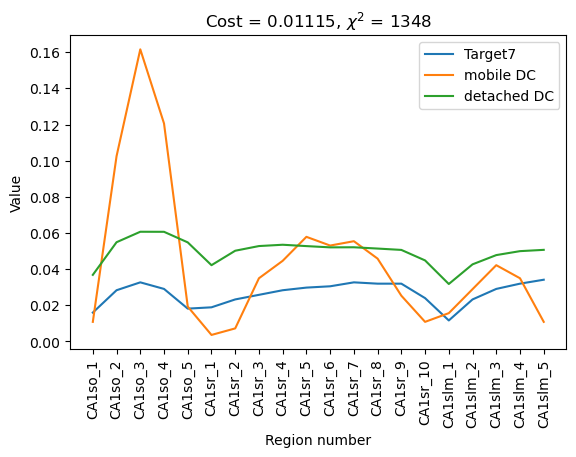

In [24]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.plot(x,model.target7,label='Target7')
ax.plot(x,resM0,label='mobile DC')
ax.plot(x,resF0/ (1 - mProp),label='detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF0 / (1 - mProp) - model.target7) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF0 / (1 - mProp) - model.target7) / model.targ7SD) ** 2),'.4g')}") 
# function to show the plot
plt.show()
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.png')
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.pdf')
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.svg')


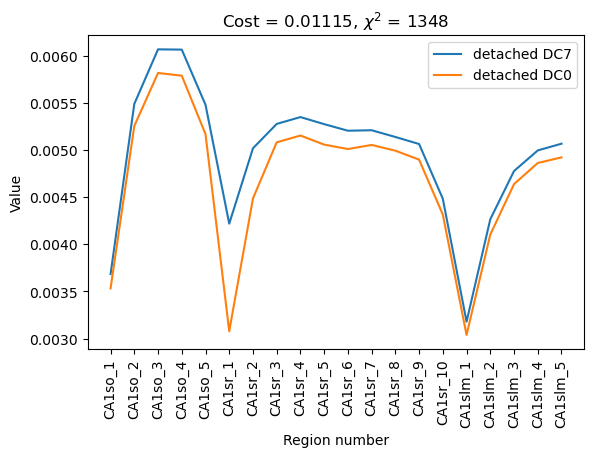

In [25]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
#ax.plot(x,model.target7,label='Target7')
ax.plot(x,resF0,label='detached DC7')
ax.plot(x,resF1,label='detached DC0')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF0 / (1 - mProp) - model.target7) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF0 / (1 - mProp) - model.target7) / model.targ7SD) ** 2),'.4g')}") 
# function to show the plot
plt.show()
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.png')
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.pdf')
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.svg')


In [ ]:
m3 = 3 * 30 * 24 * 3600 # final time point
nframes = 50
t = np.append([0],np.logspace(-0.5,math.log10(m3),nframes))
utrace = model.calcUtrace(par,time=m3,nframes=nframes)
sumTot=np.zeros(utrace.shape[1])
sumM = np.zeros(utrace.shape[1])
sumF = np.zeros(utrace.shape[1])
for i in range(utrace.shape[1]):
    resM, resF = sushibelt.aggregate_segments(utrace[:, i], segIdx, expD['Abbreviation'], fun=np.sum)
    sumTot[i] = np.sum(utrace[:-1, i])
    sumF[i] = np.sum(resF)
    sumM[i] = np.sum(resM)


In [ ]:
parnames=['F','Ctau','mProp','dvA','dvB','tr',
          'demand_CA1so_1','demand_CA1so_2','demand_CA1so_3','demand_CA1so_4','demand_CA1so_5',
          'demand_CA1sr_1','demand_CA1sr_2','demand_CA1sr_3','demand_CA1sr_4','demand_CA1sr_5',
          'demand_CA1sr_6','demand_CA1sr_7','demand_CA1sr_8','demand_CA1sr_9','demand_CA1sr_10',
          'demand_CA1slm_1','demand_CA1slm_2','demand_CA1slm_3','demand_CA1slm_4','demand_CA1slm_5']
cnames = parnames + ['Cost','CostD7','CostD0', 'Chi2D7', 'Chi2D0']
par = np.array([1,-1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
cost0 = 0
cost1 = 1
chi2_0 = 0.1
chi2_1 = 0.2
best_line = np.append(par, [(cost0+cost1),cost0,cost1,chi2_0,chi2_1])
(len(parnames),len(cnames),len(par),len(best_line))

In [ ]:
x=5
y=[7,3,3]
z=np.array([7,7,7])
len(np.append(z, [y, y]))

In [ ]:
(sumTot,sumF,sumM)

In [ ]:
plt.plot(t,sumTot,label='Total')
plt.plot(t,sumF,label='detached')
plt.plot(t,sumM,label='mobile')
plt.legend()
plt.show()

In [ ]:
x=np.array(range(expD.shape[0]),dtype=int)
for Ind in range(utrace.shape[1]):
    resM, resF = sushibelt.aggregate_segments(utrace[:, Ind], segIdx, expD['Abbreviation'], fun=np.sum)
    fig, ax = plt.subplots()
    #ax.plot(x,target,label='Deficit')
    ax.plot(x,resM,label='mobile DC')
    ax.plot(x,resF,label='detached DC')
    ax.set_xlabel('Region number')
    ax.set_ylabel('Value')
    ax.set_xticks(x,expD['Abbreviation'],rotation=90)
    # show a legend on the plot
    ax.legend()
    #plt.show()
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
    plt.title(f"Solution[{Ind}]: time={format(t[Ind],'.4g')}({format(t[Ind]/3600,'.4g')} h). Sum={format(np.sum(utrace[:-1, Ind]),'.4g')}") 
    # function to show the plot
    plt.show()
    #plt.savefig(f"Edita_20reg_1dv_soma_sol{Ind}_202407171015.png")
    #plt.savefig(f"Edita_20reg_1dv_soma_sol{Ind}_202407171015.pdf")
    #plt.savefig(f"Edita_20reg_1dv_soma_sol{Ind}_202407171015.svg")
    plt.close()


In [ ]:
x=np.array(range(expD.shape[0]),dtype=int)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
fig, ax = plt.subplots()
#ax.errorbar(x,target,targSD,label='Deficit', fmt='-o')

ax.errorbar(x,np.array(expD[f"{cname0}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]),np.array(expD[f"{cname0}_SD"])/np.sum(expD[f"{cname0}_MEAN"]),label=cname0)
ax.errorbar(x,np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname7}_MEAN"]),np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname7}_MEAN"]),label=cname7)
ax.errorbar(x,np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]),np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]),label=f"{cname7}/{cname0}")
ax.plot(x,resM,label='Mobile')
ax.plot(x,resF,label='Detached')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])


In [ ]:
x=np.array(range(expD.shape[0]),dtype=int)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
fig, ax = plt.subplots()
#ax.errorbar(x,target,targSD,label='Deficit', fmt='-o')

ax.errorbar(x,np.array(expD[f"{cname0}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]),np.array(expD[f"{cname0}_SD"])/np.sum(expD[f"{cname0}_MEAN"]),label=cname0)
ax.errorbar(x,np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname7}_MEAN"]),np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname7}_MEAN"]),label=cname7)
ax.errorbar(x,np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]),np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]),label=f"{cname7}/{cname0}")
ax.plot(x,resM/np.sum(utrace[:-1, -1]),label='Mobile')
ax.plot(x,resF/np.sum(utrace[:-1, -1]),label='Detached')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])


In [ ]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
#ax.errorbar(x,target,targSD,label='Deficit', fmt='-o')
ax.errorbar(x,expD[f"{cname0}_MEAN"],expD[f"{cname0}_SD"],label=cname0)
ax.errorbar(x,expD[f"{cname7}_MEAN"],expD[f"{cname7}_SD"],label=cname7)
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
plt.show()
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.png')
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.pdf')
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.svg')


In [ ]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.errorbar(x,target,targSD,label='Deficit', fmt='-o')
#ax.errorbar(x,expD[f"{cname0}_MEAN"],expD[f"{cname0}_SD"],label=cname0)
#ax.errorbar(x,expD[f"{cname7}_MEAN"],expD[f"{cname7}_SD"],label=cname7)
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
plt.show()
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.png')
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.pdf')
#plt.savefig('bestFitEdita_20reg_1dv_soma_202407171015best.svg')


In [ ]:
plt.errorbar(x,target,targSD,label='Deficit', fmt='-o')
#plt.plot(x,target,label='Deficit')
#plt.plot(x,nresM,label='mobile O')
plt.plot(x,resF,label='detached O')
plt.plot(x,resF/(1-mProp),label='detached norm DC')
#plt.plot(x,resM+resF,label='total DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
plt.show()
#plt.savefig('bestFitEdita_20reg_1dv_soma_resF202407171015.png')
#plt.savefig('bestFitEdita_20reg_1dv_soma_resF202407171015.pdf')
#plt.savefig('bestFitEdita_20reg_1dv_soma_resF202407171015.svg')


## Apparent degradation rate

In [ ]:
nframes = 50
utrace = calcUtrace(par,nframes=50)
t = np.logspace(-0.5,math.log10(day7),nframes)
(t,7*t/day7,utrace.shape,t.shape,utrace[:3,:])

In [ ]:
resList=[]
for i in range(nframes):
    resm, resf = sushibelt.aggregate_segments(utrace[:, i+1], segIdx, expD['Abbreviation'], fun=np.sum)
    resList.append(resf)
resfree = np.array(resList)
(resF.shape,resfree.shape)

In [ ]:
(expD.shape,expD['Abbreviation'])

In [ ]:
i = 1
bfit, afit = np.polyfit(np.log(t), np.log(resfree[:,i]), deg=1)
plt.scatter(np.log(t), np.log(resfree[:,i]))
plt.plot(np.log(t), afit + bfit * np.log(t), color="k", lw=2.5)
(bfit, afit,f'LR equation: $Y = {round(afit*1e6,3)}'+'\\ 10^{-6}'+f' + {round(bfit*1e6,3)}'+'\\ 10^{-6}\\ X$')

In [ ]:
alpha = (np.log(resfree[0,i])-np.log(resfree[-1,i]))/day7
t_half = np.log(2)*7/(alpha * day7)
(alpha, t_half,format(alpha, ".2g"))

In [ ]:
x = 7*t/day7
alpha = np.zeros(expD.shape[0])
for i in range(expD.shape[0]):
    alpha[i] = (np.log(resfree[0,i])-np.log(resfree[-1,i]))/day7
    t_half = np.log(2)*7/(alpha[i] * day7)
    plt.plot(x,resfree[:,i],label=f"{expD['Abbreviation'][i]}")
    plt.scatter(x,resfree[:,i])
    plt.ylabel('Value')
    plt.xlabel('Time (days)')
    # show a legend on the plot
    plt.legend()
    plt.title(f"{expD['Abbreviation'][i]}: $\\alpha$ = {format(alpha[i], '.2g')}, T = {format(t_half, '.2g')} days.") 
    #plt.show()
    plt.savefig(f"Edita_20reg_1dv_resF_{expD['Abbreviation'][i]}_202406161015.png")
    plt.savefig(f"Edita_20reg_1dv_resF_{expD['Abbreviation'][i]}_202406161015.pdf")
    plt.savefig(f"Edita_20reg_1dv_resF_{expD['Abbreviation'][i]}_202406161015.svg")
    plt.close()



In [ ]:
x = 7*t/day7
alpha = np.zeros(expD.shape[0])
fig, ax = plt.subplots()
for i in range(expD.shape[0]):
    alpha[i] = (np.log(resfree[0,i])-np.log(resfree[-1,i]))/day7
    t_half = np.log(2)*7/(alpha[i] * day7)
    ax.plot(x,resfree[:,i],label=f"{expD['Abbreviation'][i]}")
    ax.scatter(x,resfree[:,i])
ax.set_ylabel('Value')
ax.set_xlabel('Time (days)')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.85, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
# show a legend on the plot
plt.savefig(f"Edita_20reg_1dv_resF_202406161015.png")
plt.savefig(f"Edita_20reg_1dv_resF_202406161015.pdf")
plt.savefig(f"Edita_20reg_1dv_resF_202406161015.svg")



In [ ]:
x = 7*t/day7
alpha = np.zeros(expD.shape[0])
fig, axes = plt.subplots(5, 4, figsize=(16, 20))

k = 0
for i in range(5):
    for j in range(4):
        alpha[k] = (np.log(resfree[0,k])-np.log(resfree[-1,k]))/day7
        t_half = np.log(2)*7/(alpha[k] * day7)
        axes[i,j].plot(x,resfree[:,k],label=f"{expD['Abbreviation'][k]}")
        axes[i,j].scatter(x,resfree[:,k])
        axes[i,j].legend()
        if i == 4 :
            axes[i,j].set_xlabel('Time (days)')
        if j == 0 :
            axes[i,j].set_ylabel('Value')
        k += 1
#plt.ylabel('Value')
#plt.xlabel('Time (days)')
# show a legend on the plot
#plt.legend(bbox_to_anchor = (1.05,1.04),loc='upper left')
plt.savefig(f"Edita_20reg_1dv_resF_panels_202406161015.png")
plt.savefig(f"Edita_20reg_1dv_resF_panels_202406161015.pdf")
plt.savefig(f"Edita_20reg_1dv_resF_panels_202406161015.svg")



In [ ]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

axes[0].plot(x,np.log(2)*7/(alpha * day7),label='half-life (days)')
#axes[0].xlabel('Region number')
#axes[0].ylabel('Apparent half-life (days)')
# show a legend on the plot
axes[0].legend()
plt.xticks(x,expD['Abbreviation'],rotation=90)
axes[1].plot(x,par[5:],label=f'Demand')
#axes[1].xlabel('Region number')
#axes[1].ylabel('Demand')
# show a legend on the plot
axes[1].legend()
#plt.show()
plt.savefig('Edita_20reg_1dv_A_demand202406161015.png')
plt.savefig('Edita_20reg_1dv_A_demand202406161015.pdf')
plt.savefig('Edita_20reg_1dv_A_demand202406161015.svg')


In [ ]:
A = (np.log(expD[f"{cname0}_MEAN"])-np.log(expD[f"{cname7}_MEAN"]))/day7
fig, ax = plt.subplots()
ax.plot(x,np.log(2)*7/(A * day7),label='half-life (days)')
ax.set_xlabel('Region number')
ax.set_ylabel('Apparent half-life (days)')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.savefig('Edita_20reg_1dv_A_202406161015.png')
plt.savefig('Edita_20reg_1dv_A_202406161015.pdf')
plt.savefig('Edita_20reg_1dv_A_202406161015.svg')


In [ ]:
fig, ax = plt.subplots()
ax.plot(x,par[5:],label=f'Demand')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.savefig('Edita_20reg_1dv_demand202406161015.png')
plt.savefig('Edita_20reg_1dv_demand202406161015.pdf')
plt.savefig('Edita_20reg_1dv_demand202406161015.svg')


In [ ]:
COLOR_alpha = "#69b3a2"
COLOR_demand = "#3399e6"
fig, ax1 = plt.subplots(figsize=(8, 6))
# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylim(0, 1)
ax1.plot(x,np.log(2)*7/(alpha * day7),color = COLOR_alpha)
ax1.set_ylabel('Apparent half-life (days)',color = COLOR_alpha)
ax2.plot(x,par[5:],color = COLOR_demand)
ax2.set_ylabel('Demand',color = COLOR_demand)
ax1.set_xticks(x,expD['Abbreviation'],rotation=90)
pos = ax1.get_position()
ax1.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#pos = ax2.get_position()
#ax2.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#plt.show()
plt.savefig('Edita_20reg_1dv_Ademand202406161015.png')
plt.savefig('Edita_20reg_1dv_Ademand202406161015.pdf')
plt.savefig('Edita_20reg_1dv_Ademand202406161015.svg')


In [ ]:
bfit, afit = np.polyfit(par[5:],np.log(2)*7/(A * day7), deg=1)
xseq = np.linspace(min(par[5:]), max(par[5:]), num=100)
plt.scatter(par[5:],np.log(2)*7/(A * day7))
plt.plot(xseq, afit + bfit * xseq, color="k", lw=2.5)
plt.text(0, 13, f'LR equation: $Y = {round(afit,3)} + {round(bfit,3)} X$', fontsize=10)
plt.xlabel('Demand')
plt.ylabel('Apparent half-life (days)')
# show a legend on the plot
#plt.show()
plt.savefig('Edita_20reg_1dv_A_vs_demand202406161015.png')
plt.savefig('Edita_20reg_1dv_A_vs_demand202406161015.pdf')
plt.savefig('Edita_20reg_1dv_A_vs_demand202406161015.svg')


Day 7 3 weeks
----

In [ ]:
bgSignal = 1e-5
cname0='D0W3'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

cname7='D7W3'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #measurement errors
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point

itarg = np.ones(N, dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= (i+5)

#par = [0.111784701917933,-1,0.584647952749801,-5.40926182202759,-7.58373647291078,0.93075347720533,0.150119155946245,0.250026616923097,0.247923892623914,1,0.829698078092076,0.799680386796054,0.435204401984173,0.776990953492751,0.658564397472255,0.669466722069782,0.13217494651507,0.452337127435389,0.818398235362628,0.287266237055001,0.693374804035749,0.387600533946115,0.860396244028168,0.793857689742176,0.00234423876609767]
#cost=0.2289827
#par = [0.141527769926587,-1.04440055844237,0.381706990604462,-5.43766625150405,-12.234744035647,1,0.164098437336494,0.272405308568442,0.427804635567134,0.812746641751752,0.919149761897559,0.672064846552212,0.149965791068772,0.539839422213906,0.812188937409397,0.806685239524521,0.165041822978698,0.529423937850048,0.828384035574742,0.221525313745652,0.676304529167494,0.634182580029409,0.814899037032692,0.790009814378913,0.0884319910464033]
#cost=0.1914477
#par = [1.0,-18.0,0.339665263904274,-18.0,-0.1056091212860899,1.0,0.06274608035463802,4.4574543322602384e-07,0.02193672327975435,0.0870196802604857,8.738149616920519e-07,1.0,0.23641992030781905,0.20499095398769174,3.3139951083305927e-07,0.0264354594647535,1.0601425384202188e-07,0.018642526550405554,1.3229426155908984e-07,0.321659768251798,1.256853193752937e-06,0.9999991575763989,0.9008918582308576,1.0002936595814933e-07,1.0]
#cost = 0.00972634
#par = [0.18124010722657255,-18.0,0.4770849437408547,-18.0,-7.528208406834074,0.6335729107600226,0.28276999275111847,0.558910113544302,1.0,0.3929830308454687,0.2992123958197709,0.753091076326252,1.0,0.17238067898531845,1.0,1e-07,1.0,0.04290036974800929,0.9692956552909402,1.0,0.5346212757781438,1.0,0.28625682786833306,1e-07,1e-07]
#cost = 0.02659
#par = [0.32023059450279123,-6.327308855004608,0.627385538130974,-18.0,-17.999431588729976,0.06854654347167044,0.060486839296889444,0.04484900714349323,0.03490854158366522,0.00024252729610862994,0.32943753444660906,0.4029203029951907,0.12801603593190886,0.14871930210853104,0.14171491277653797,0.18024101228415457,0.18628112282529372,0.23357327869041905,0.4302044118823936,0.5008667022509936,0.0038157043176590766,0.2007104314288199,0.22494314014617123,0.31189759389623783,0.9999999999990268]
#cost = 0.001142
#par = [0.01385481065982917,-6.226265838840085,0.6709771115511489,-17.995913305482574,-16.696101588995024,0.21868548101204954,0.06211405206769383,0.048882353452234434,0.046632773486508856,1.9401449712242143e-06,0.7864443640945032,0.5632548318074286,0.14915702983161863,0.1491589398028194,0.13322800132469398,0.15668388533325328,0.17435550169553826,0.20436446923690443,0.37541096611836217,0.5260391371129066,0.043995168941356404,0.1970021740399707,0.19622524557390722,0.2758337024352678,0.9999999999613025]
#cost = 1.51e-09
par = [0.8861278052764772,-5.358123919558814,0.3127455791698551,-5.7356821635860165,-17.999032750284783,0.21382364663804718,0.06074280874523973,0.04781382417616123,0.04562340830020193,1.0000000000039887e-07,0.7733439929081787,0.5543045057407645,0.1468913931288651,0.14710118884157364,0.1316203146580693,0.15499357159791044,0.17296720163305693,0.20287137824434023,0.3735878952746845,0.5243019440900127,0.043864102155039865,0.1966480252602025,0.19591970216660096,0.2755074889018492,0.9999999999999992]
cost = 3.331839554992909e-11
mProp = par[2]
utrace = calcUtrace(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)


In [ ]:
{'F' : par[0],
'Ctau' : 10 ** par[1],
'mProp' : par[2],
'dvA': 10 ** par[3],
'dvB': 10 ** par[4],
'demand_CA1so_1' : par[5],
'demand_CA1so_2' : par[6],
'demand_CA1so_3' : par[7],
'demand_CA1so_4' : par[8],
'demand_CA1so_5' : par[9],
'demand_CA1sr_1' : par[10],
'demand_CA1sr_2' : par[11],
'demand_CA1sr_3' : par[12],
'demand_CA1sr_4' : par[13],
'demand_CA1sr_5' : par[14],
'demand_CA1sr_6' : par[15],
'demand_CA1sr_7' : par[16],
'demand_CA1sr_8' : par[17],
'demand_CA1sr_9' : par[18],
'demand_CA1sr_10' : par[19],
'demand_CA1slm_1' : par[20],
'demand_CA1slm_2' : par[21],
'demand_CA1slm_3' : par[22],
'demand_CA1slm_4' : par[23],
'demand_CA1slm_5' : par[24],
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost
}

In [ ]:
x=np.array(range(expD.shape[0]),dtype=int)

plt.plot(x,target,label=cname)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
plt.plot(x,resM,label='mobile DC')
plt.plot(x,resF,label='detached DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {np.sum((resF/(1-mProp) - target) ** 2)}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_3w_202406161015best.png')
plt.savefig('bestFitEdita_20reg_1dv_3w_202406161015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_3w_202406161015best.svg')


In [ ]:
plt.plot(x,target,label=cname)
plt.plot(x,resF,label='detached DC')
plt.plot(x,resF/(1-mProp),label='detached norm DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {np.sum((resF/(1-mProp) - target) ** 2)}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_3w_de_202406161015best.png')
plt.savefig('bestFitEdita_20reg_1dv_3w_de_202406161015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_3w_de_202406161015best.svg')


Day 0 18 month
----

In [ ]:
cname='D0M318'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
bgSignal = 1e-5
cname='D0M318'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

cname7='D7M318'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #measurement errors
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point

itarg = np.ones(N, dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= (i+5)

#par = [0.111784701917933,-1,0.584647952749801,-5.40926182202759,-7.58373647291078,0.93075347720533,0.150119155946245,0.250026616923097,0.247923892623914,1,0.829698078092076,0.799680386796054,0.435204401984173,0.776990953492751,0.658564397472255,0.669466722069782,0.13217494651507,0.452337127435389,0.818398235362628,0.287266237055001,0.693374804035749,0.387600533946115,0.860396244028168,0.793857689742176,0.00234423876609767]
#cost=0.2289827
#par = [0.141527769926587,-1.04440055844237,0.381706990604462,-5.43766625150405,-12.234744035647,1,0.164098437336494,0.272405308568442,0.427804635567134,0.812746641751752,0.919149761897559,0.672064846552212,0.149965791068772,0.539839422213906,0.812188937409397,0.806685239524521,0.165041822978698,0.529423937850048,0.828384035574742,0.221525313745652,0.676304529167494,0.634182580029409,0.814899037032692,0.790009814378913,0.0884319910464033]
#cost=0.1914477
#par = [1.0,-18.0,0.339665263904274,-18.0,-0.1056091212860899,1.0,0.06274608035463802,4.4574543322602384e-07,0.02193672327975435,0.0870196802604857,8.738149616920519e-07,1.0,0.23641992030781905,0.20499095398769174,3.3139951083305927e-07,0.0264354594647535,1.0601425384202188e-07,0.018642526550405554,1.3229426155908984e-07,0.321659768251798,1.256853193752937e-06,0.9999991575763989,0.9008918582308576,1.0002936595814933e-07,1.0]
#cost = 0.00972634
#par = [0.18124010722657255,-18.0,0.4770849437408547,-18.0,-7.528208406834074,0.6335729107600226,0.28276999275111847,0.558910113544302,1.0,0.3929830308454687,0.2992123958197709,0.753091076326252,1.0,0.17238067898531845,1.0,1e-07,1.0,0.04290036974800929,0.9692956552909402,1.0,0.5346212757781438,1.0,0.28625682786833306,1e-07,1e-07]
#cost = 0.02659
#par = [0.32023059450279123,-6.327308855004608,0.627385538130974,-18.0,-17.999431588729976,0.06854654347167044,0.060486839296889444,0.04484900714349323,0.03490854158366522,0.00024252729610862994,0.32943753444660906,0.4029203029951907,0.12801603593190886,0.14871930210853104,0.14171491277653797,0.18024101228415457,0.18628112282529372,0.23357327869041905,0.4302044118823936,0.5008667022509936,0.0038157043176590766,0.2007104314288199,0.22494314014617123,0.31189759389623783,0.9999999999990268]
#cost = 0.001142
#par = [0.01385481065982917,-6.226265838840085,0.6709771115511489,-17.995913305482574,-16.696101588995024,0.21868548101204954,0.06211405206769383,0.048882353452234434,0.046632773486508856,1.9401449712242143e-06,0.7864443640945032,0.5632548318074286,0.14915702983161863,0.1491589398028194,0.13322800132469398,0.15668388533325328,0.17435550169553826,0.20436446923690443,0.37541096611836217,0.5260391371129066,0.043995168941356404,0.1970021740399707,0.19622524557390722,0.2758337024352678,0.9999999999613025]
#cost = 1.51e-09
par = [0.8861278052764772,-5.358123919558814,0.3127455791698551,-5.7356821635860165,-17.999032750284783,0.21382364663804718,0.06074280874523973,0.04781382417616123,0.04562340830020193,1.0000000000039887e-07,0.7733439929081787,0.5543045057407645,0.1468913931288651,0.14710118884157364,0.1316203146580693,0.15499357159791044,0.17296720163305693,0.20287137824434023,0.3735878952746845,0.5243019440900127,0.043864102155039865,0.1966480252602025,0.19591970216660096,0.2755074889018492,0.9999999999999992]
cost = 3.331839554992909e-11
mProp = par[2]
utrace = calcUtrace(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)


In [ ]:
{'F' : par[0],
'Ctau' : 10 ** par[1],
'mProp' : par[2],
'dvA': 10 ** par[3],
'dvB': 10 ** par[4],
'demand_CA1so_1' : par[5],
'demand_CA1so_2' : par[6],
'demand_CA1so_3' : par[7],
'demand_CA1so_4' : par[8],
'demand_CA1so_5' : par[9],
'demand_CA1sr_1' : par[10],
'demand_CA1sr_2' : par[11],
'demand_CA1sr_3' : par[12],
'demand_CA1sr_4' : par[13],
'demand_CA1sr_5' : par[14],
'demand_CA1sr_6' : par[15],
'demand_CA1sr_7' : par[16],
'demand_CA1sr_8' : par[17],
'demand_CA1sr_9' : par[18],
'demand_CA1sr_10' : par[19],
'demand_CA1slm_1' : par[20],
'demand_CA1slm_2' : par[21],
'demand_CA1slm_3' : par[22],
'demand_CA1slm_4' : par[23],
'demand_CA1slm_5' : par[24],
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost
}

In [ ]:
x=np.array(range(expD.shape[0]),dtype=int)

plt.plot(x,target,label=cname)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
plt.plot(x,resM,label='mobile DC')
plt.plot(x,resF,label='detached DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {np.sum((resF/(1-mProp) - target) ** 2)}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_18m_202406161015best.png')
plt.savefig('bestFitEdita_20reg_1dv_18m_202406161015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_18m_202406161015best.svg')


In [ ]:
plt.plot(x,target,label=cname)
plt.plot(x,resF,label='detached DC')
plt.plot(x,resF/(1-mProp),label='detached norm DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {np.sum((resF/(1-mProp) - target) ** 2)}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_18m_de_202406161015best.png')
plt.savefig('bestFitEdita_20reg_1dv_18m_de_202406161015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_18m_de_202406161015best.svg')


In [ ]:
bgSignal = 1e-5
cname='D0M318'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

cname7='D7M318'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point

itarg = np.ones(N, dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= (i+5)

#par = [0.111784701917933,-1,0.584647952749801,-5.40926182202759,-7.58373647291078,0.93075347720533,0.150119155946245,0.250026616923097,0.247923892623914,1,0.829698078092076,0.799680386796054,0.435204401984173,0.776990953492751,0.658564397472255,0.669466722069782,0.13217494651507,0.452337127435389,0.818398235362628,0.287266237055001,0.693374804035749,0.387600533946115,0.860396244028168,0.793857689742176,0.00234423876609767]
#cost=0.2289827
#par = [0.141527769926587,-1.04440055844237,0.381706990604462,-5.43766625150405,-12.234744035647,1,0.164098437336494,0.272405308568442,0.427804635567134,0.812746641751752,0.919149761897559,0.672064846552212,0.149965791068772,0.539839422213906,0.812188937409397,0.806685239524521,0.165041822978698,0.529423937850048,0.828384035574742,0.221525313745652,0.676304529167494,0.634182580029409,0.814899037032692,0.790009814378913,0.0884319910464033]
#cost=0.1914477
#par = [1.0,-18.0,0.339665263904274,-18.0,-0.1056091212860899,1.0,0.06274608035463802,4.4574543322602384e-07,0.02193672327975435,0.0870196802604857,8.738149616920519e-07,1.0,0.23641992030781905,0.20499095398769174,3.3139951083305927e-07,0.0264354594647535,1.0601425384202188e-07,0.018642526550405554,1.3229426155908984e-07,0.321659768251798,1.256853193752937e-06,0.9999991575763989,0.9008918582308576,1.0002936595814933e-07,1.0]
#cost = 0.00972634
#par = [0.18124010722657255,-18.0,0.4770849437408547,-18.0,-7.528208406834074,0.6335729107600226,0.28276999275111847,0.558910113544302,1.0,0.3929830308454687,0.2992123958197709,0.753091076326252,1.0,0.17238067898531845,1.0,1e-07,1.0,0.04290036974800929,0.9692956552909402,1.0,0.5346212757781438,1.0,0.28625682786833306,1e-07,1e-07]
#cost = 0.02659
#par = [0.32023059450279123,-6.327308855004608,0.627385538130974,-18.0,-17.999431588729976,0.06854654347167044,0.060486839296889444,0.04484900714349323,0.03490854158366522,0.00024252729610862994,0.32943753444660906,0.4029203029951907,0.12801603593190886,0.14871930210853104,0.14171491277653797,0.18024101228415457,0.18628112282529372,0.23357327869041905,0.4302044118823936,0.5008667022509936,0.0038157043176590766,0.2007104314288199,0.22494314014617123,0.31189759389623783,0.9999999999990268]
#cost = 0.001142
#par = [0.01385481065982917,-6.226265838840085,0.6709771115511489,-17.995913305482574,-16.696101588995024,0.21868548101204954,0.06211405206769383,0.048882353452234434,0.046632773486508856,1.9401449712242143e-06,0.7864443640945032,0.5632548318074286,0.14915702983161863,0.1491589398028194,0.13322800132469398,0.15668388533325328,0.17435550169553826,0.20436446923690443,0.37541096611836217,0.5260391371129066,0.043995168941356404,0.1970021740399707,0.19622524557390722,0.2758337024352678,0.9999999999613025]
#cost = 1.51e-09
par = [0.011960345815859388,-6.1560182735353965,0.6322461221196034,-17.996047147139713,-14.959974070995255,0.18567649862045055,0.056957528670173674,0.04551053808006017,0.04135084126510395,1.649345400964059e-06,0.8619022526061755,0.5207674785364464,0.14814170051851783,0.15883549622889548,0.13808141629856768,0.16920384076191758,0.18298699855958261,0.22886833570021548,0.38449131150036275,0.4486247853671589,0.04717614725356932,0.2153646950670156,0.20077012049301557,0.28832308301186405,0.9999999998367075]
cost = 0.0009545314744344554
utrace = calcUtrace(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)


In [ ]:
{'F' : par[0],
'Ctau' : 10 ** par[1],
'mProp' : par[2],
'dvA': 10 ** par[3],
'dvB': 10 ** par[4],
'demand_CA1so_1' : par[5],
'demand_CA1so_2' : par[6],
'demand_CA1so_3' : par[7],
'demand_CA1so_4' : par[8],
'demand_CA1so_5' : par[9],
'demand_CA1sr_1' : par[10],
'demand_CA1sr_2' : par[11],
'demand_CA1sr_3' : par[12],
'demand_CA1sr_4' : par[13],
'demand_CA1sr_5' : par[14],
'demand_CA1sr_6' : par[15],
'demand_CA1sr_7' : par[16],
'demand_CA1sr_8' : par[17],
'demand_CA1sr_9' : par[18],
'demand_CA1sr_10' : par[19],
'demand_CA1slm_1' : par[20],
'demand_CA1slm_2' : par[21],
'demand_CA1slm_3' : par[22],
'demand_CA1slm_4' : par[23],
'demand_CA1slm_5' : par[24],
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF - target) ** 2),
'err_norm' : np.sum((resF - target) ** 2)/tnorm,
'cost' : cost
}

In [ ]:
x=np.array(range(expD.shape[0]),dtype=int)

plt.plot(x,target,label=cname)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
plt.plot(x,resM,label='mobile DC')
plt.plot(x,resF,label='detached DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {np.sum((resF - target) ** 2)/tnorm}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_18m_nm_202404151015best.png')
plt.savefig('bestFitEdita_20reg_1dv_18m_nm_202404151015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_18m_nm_202404151015best.svg')


In [ ]:
plt.plot(x,target,label=cname)
plt.plot(x,resF,label='detached DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {np.sum((resF - target) ** 2)/tnorm}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_18m_de_nm_202404151015best.png')
plt.savefig('bestFitEdita_20reg_1dv_18m_de_nm_202404151015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_18m_de_nm_202404151015best.svg')
